### Ideas for features
- density of fields
- which side of river
- distance from river
- distance along river

In [164]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [166]:
train_test_shp = gpd.read_file('../data/train_test_shp')

In [167]:
orange_river_segment_shp = gpd.read_file('../data/orange_river_segment/'
                                        ).to_crs({'init': 'epsg:32734'})

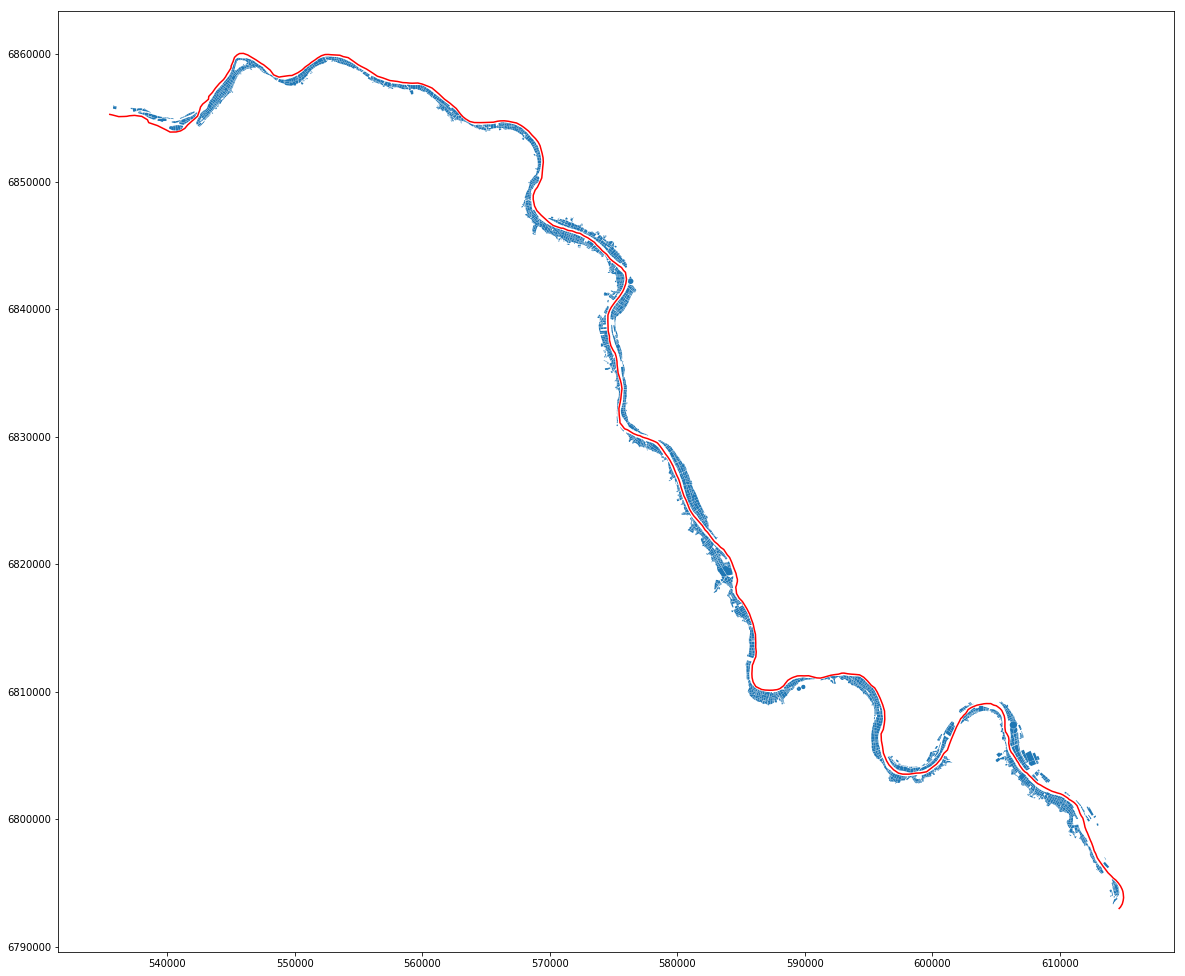

In [168]:
ax = train_test_shp.plot(figsize=(20,20))
orange_river_segment_shp.plot(figsize=(20,20),ax=ax, color = 'red')

In [216]:

from shapely.geometry import MultiPoint, Point
from shapely.ops import split, snap, nearest_points

def nearest_neighbor_within(others, point, max_distance):
    """Find nearest point among others up to a maximum distance.
    
    Args:
        others: a list of Points or a MultiPoint
        point: a Point
        max_distance: maximum distance to search for the nearest neighbor
        
    Returns:
        A shapely Point if one is within max_distance, None otherwise
    """
    search_region = point.buffer(max_distance)
    interesting_points = search_region.intersection(MultiPoint(others))
    
    if not interesting_points:
        closest_point = None
    elif isinstance(interesting_points, Point):
        closest_point = interesting_points
    else:            
        distances = [point.distance(ip) for ip in interesting_points
                     if point.distance(ip) > 0]
        closest_point = interesting_points[distances.index(min(distances))]
    
    return closest_point

def get_distance_along_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid

    split_line = split(line, nearest_neighbor_within(line.coords,point,tolerance))
    
    return split_line[0].length

def get_distance_from_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid
    
    return point.distance(nearest_neighbor_within(line.coords,point,tolerance))

def get_side_of_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid
    
    nearest_point = nearest_neighbor_within(line.coords,point,tolerance)
    
    if (nearest_point.coords.xy[0] < point.coords.xy[0] 
        and nearest_point.coords.xy[1] < point.coords.xy[1]):
        return 'NE'
    else:
        return 'SW'
    
    return point.distance()

In [202]:
train_test_shp['distance_along_river'] = train_test_shp.geometry.apply(
    lambda x: get_distance_along_line(orange_river_segment_shp, x))

In [203]:
train_test_shp['distance_from_river'] = train_test_shp.geometry.apply(
    lambda x: get_distance_from_line(orange_river_segment_shp, x))

In [217]:
train_test_shp['side_of_river'] = train_test_shp.geometry.apply(
    lambda x: get_side_of_line(orange_river_segment_shp, x))

In [218]:
train_test_shp['side_of_river'].value_counts()

SW    3016
NE     552
Name: side_of_river, dtype: int64